In [3]:
from ResSimulator import NBResonator
from scipy.signal import windows, convolve
from TrappingSimulator import QPtrapper
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm
import numpy as np
import matplotlib.pyplot as plt

savepath = r"G:\Shared drives\LFL\Simulations\James\NBR07\vsFlux\\"

import os
if not os.path.exists(savepath):
    os.makedirs(savepath)

# phis = [0.346,0.382,0.417,0.45,0.467]
# fds = [4.29151e9,4.28803e9,4.28348e9,4.27726e9,4.27739e9]
phis = [0.467]
fds = [4.27339e9]

{'fd': 4273390000.0, 'f0': 4273474495.8096886, 'Qt': 16987.17948717949, 'Qi': 53000, 'Qe': 25000, 'N': 6000000, 'q': 0.02429484294393876, 'photonRO': 45, 'sampleRate': 300000000.0, 'kappa': 1580664.5348595425, 'fwhm': 251570.5740929477, 'diameter': 1.358974358974359, 'freq_shift': 220797.25053330624, 'SNR': 0.024924225145359365, 'SNRdB': -16.033783343332782, 'sigma': 6.334162009426515}


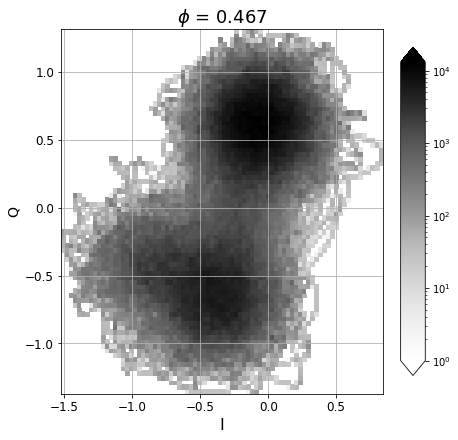

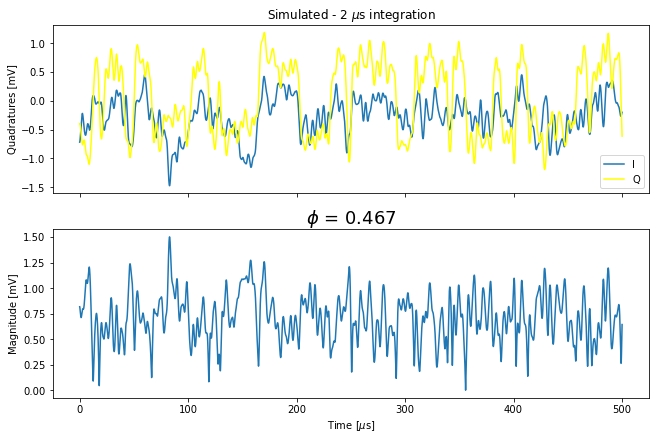

In [4]:
for f,ph in zip(fds,phis):
    ## definition of parameters used in QP trapper

    duration = 0.02 # seconds to record data
    sampleRate = 300e6
    N = int(duration*sampleRate)
    tauTrap = 40e-6
    tauRelease = 10e-6
    tauCommon = 1e-4
    tauRare = 7e-1
    tauRecomb = 1.5e-4
    phi = ph
    Lj = 20.8475e-12 # squid inductance at zero phase bias
    # Lj = 31.7299e-12
    args = {'N':N,'Lj':Lj,'tauTrap':tauTrap,'tauRelease':tauRelease,'tauCommon':tauCommon,'tauRare':tauRare,
            'tauRecomb':tauRecomb,'sampleRate':sampleRate,'phi':phi,'Delta':2.72370016e-23,'T':0.010}

    trapper = QPtrapper(**args)
    
    L = 1.82897e-9
    C = 0.739929e-12
    # L = 2.7837e-9
    # C = 0.486155e-12
    Qi = 53000
    Qe = 25000
    photonRO = 45
    photonNoise = 3
    fd = f

    resArgs = {'L':L,'C':C,'photonRO':photonRO,'photonNoise':photonNoise,'Qi':Qi,'Qe':Qe,'sampleRate':sampleRate,'fd':fd}

    res = NBResonator(trapper,**resArgs)

    print(res.dParams)
    
    # integrate
    tau = 5
    nAvg = int(max(tau*1e-6*res.dParams['sampleRate'],1))
    window = windows.hann(nAvg)
    rhann = convolve(res.signal.real,window,mode='same')/sum(window)
    ihann = convolve(res.signal.imag,window,mode='same')/sum(window)
    
    # complex hist
    fig = plt.figure(figsize=[9,6],constrained_layout=True)
    h = fig.add_subplot()
    hs = plt.hist2d(rhann,ihann,bins=(80,80),norm=LogNorm(),cmap=plt.get_cmap('Greys'))
    hb = plt.colorbar(hs[-1], shrink=0.9, extend='both')
    h.set_aspect('equal')
    h.grid()
    h.set_xlabel('I',fontsize=16)
    h.set_ylabel('Q',fontsize=14)
    h.set_title('$\phi$ = {}'.format(ph),fontsize=18)
    h.tick_params(labelsize=12)
    plt.savefig(savepath+r'IQhist_phi_{}.png'.format(int(ph*1000)),format='png')
    plt.show()
    plt.close()

    # time series
    time = np.arange(res.dParams['N'])/res.dParams['sampleRate']
#     time = np.mean(time[:len(res.signal)//(nAvg)*nAvg].reshape((len(res.signal)//(nAvg),nAvg)),axis=1)
    pltmask = np.logical_and(time > 3e-3, time < 3.5e-3)
    plttime = time[pltmask]*1e6 - 3000
    fig,ax = plt.subplots(2,1,sharex=True,figsize=[9,6],constrained_layout=True)
    # ax[0].plot(time*1e3,np.arctan((ihann/rhann)))
    # ax[0].set_ylabel('phase [rad]')
    # ax[1].plot(time*1e3,np.sqrt(rhann**2 + ihann**2))
    # ax[1].set_ylabel('Magnitude')
    # ax[1].set_xlabel('time [ms]')
    ax[0].plot(plttime,rhann[pltmask], label='I')
    ax[0].plot(plttime,ihann[pltmask], color='yellow',label = 'Q')
    ax[0].set_title('Simulated - 2 $\mu$s integration')
    ax[0].set_ylabel('Quadratures [mV]')
    ax[0].legend()
    ax[1].plot(plttime,np.abs(rhann[pltmask] + 1j*ihann[pltmask]))
    ax[1].set_ylabel('Magnitude [mV]')
    ax[1].set_xlabel('Time [$\mu$s]')
    plt.title('$\phi$ = {}'.format(ph),fontsize=18)
    plt.savefig(savepath+r'timeseries_phi_{}.png'.format(int(ph*1000)),format='png')
    plt.show()
    plt.close()